In [2]:
import statsmodels.api as sm
import scipy as sp
import matplotlib.pylab as plt
import seaborn as sns
import scipy.stats
import warnings
warnings.filterwarnings(action='ignore')
import matplotlib as mpl
set(sorted([f.name for f in mpl.font_manager.fontManager.ttflist]))
# 폰트 설정
mpl.rc('font', family='NanumGothic')

In [2]:
from sklearn.datasets import make_regression

X0, y, coef = make_regression(n_samples=100, n_features=1, noise=20,
                              coef=True, random_state=0)
coef

array(42.38550486)

In [3]:
dfX0 = pd.DataFrame(X0, columns=["X1"])
dfX = sm.add_constant(dfX0)
dfy = pd.DataFrame(y, columns=["y"])

model = sm.OLS(dfy, dfX)
result = model.fit()

In [4]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     400.3
Date:                Tue, 19 May 2020   Prob (F-statistic):           2.21e-36
Time:                        15:51:22   Log-Likelihood:                -448.09
No. Observations:                 100   AIC:                             900.2
Df Residuals:                      98   BIC:                             905.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6284      2.163     -0.753      0.4

In [5]:
print(result.t_test("X1 = 40"))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            42.8534      2.142      1.332      0.186      38.603      47.104


```
단일계수 t검정의 사용
두 독립변수의 계수값을 비교할 때도 쓸 수 있다. 
범주형 독립변수의 범주값이 가지는 유의성을 판단하는데 유용하다.
```

In [6]:
# nottem데이터의 각 월 비교
import datetime
from calendar import isleap

df_nottem = sm.datasets.get_rdataset("nottem").data 

def convert_partial_year(number):
    year = int(number)
    d = datetime.timedelta(days=(number - year) * (365 + isleap(year)))
    day_one = datetime.datetime(year, 1, 1)
    date = d + day_one
    return date

df_nottem["date0"] = df_nottem[["time"]].applymap(convert_partial_year)
df_nottem["date"] = pd.DatetimeIndex(df_nottem["date0"]).round('60min') + datetime.timedelta(seconds=3600*24)
df_nottem["month"] = df_nottem["date"].dt.strftime("%m").astype('category')
del df_nottem["date0"], df_nottem["date"]

model_nottem = sm.OLS.from_formula("value ~ C(month) + 0", df_nottem)
result_nottem = model_nottem.fit()
print(result_nottem.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     277.3
Date:                Tue, 19 May 2020   Prob (F-statistic):          2.96e-125
Time:                        15:51:26   Log-Likelihood:                -535.82
No. Observations:                 240   AIC:                             1096.
Df Residuals:                     228   BIC:                             1137.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
C(month)[01]    39.6950      0.518     76.691   

```
축소랭크 방식을 사용하면
기준값이 되는 범주와 각 월을 비교
기준값이 아닌 월과의 비교를 하고싶다면?
```

In [7]:
# 1월과 2월의 기온이 실질적으로 같은지
# 귀무가설 기각할 근거 불충분 같다고 볼 수 있다
print(result_nottem.t_test("C(month)[01] = C(month)[02]"))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.5050      0.732      0.690      0.491      -0.937       1.947


In [8]:
# 3월과 2월의 비교
print(result_nottem.t_test("C(month)[03] = C(month)[02]"))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             3.0050      0.732      4.105      0.000       1.563       4.447


### statsmodels를 이용한 레버리지값 계산

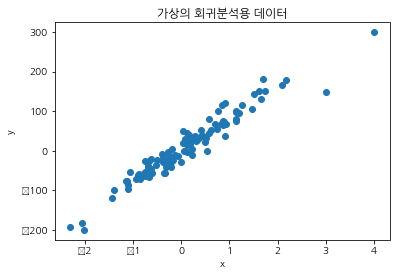

In [9]:
from sklearn.datasets import make_regression

# 100개의 데이터 생성
X0, y, coef = make_regression(n_samples=100, n_features=1, noise=20,
                              coef=True, random_state=1)

# 레버리지가 높은 가상의 데이터(100,101번 데이터)를 추가
data_100 = (4, 300)
data_101 = (3, 150)
X0 = np.vstack([X0, np.array([data_100[:1], data_101[:1]])])
X = sm.add_constant(X0)
y = np.hstack([y, [data_100[1], data_101[1]]])

plt.scatter(X0, y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("가상의 회귀분석용 데이터")
plt.show()

In [10]:
# 회귀분석 결과
model = sm.OLS(pd.DataFrame(y), pd.DataFrame(X))
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      0   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     1464.
Date:                Tue, 19 May 2020   Prob (F-statistic):           1.61e-61
Time:                        15:51:27   Log-Likelihood:                -452.71
No. Observations:                 102   AIC:                             909.4
Df Residuals:                     100   BIC:                             914.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              3.2565      2.065      1.577      0.1

get_influence 메서드를 호출하면 영향도 정보 객체를 구할 수 있다. 
이 객체는 hat_matrix_diag 속성으로 레버리지 벡터의 값을 가지고 있다.

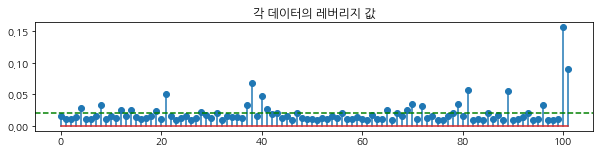

In [11]:
influence = result.get_influence()
hat = influence.hat_matrix_diag

plt.figure(figsize=(10, 2))
plt.stem(hat)
# 0.02=평균 레버리지 값 N=102, K=2
plt.axhline(0.02, c="g", ls="--")
plt.title("각 데이터의 레버리지 값")
plt.show()

In [12]:
# 레버리지의 합은 K
hat.sum()

2.0000000000000004

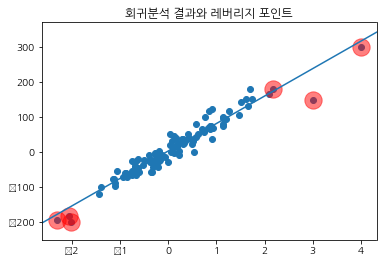

In [13]:
# 레버리지가 큰 데이터에 인덱싱
ax = plt.subplot()
plt.scatter(X0, y)
sm.graphics.abline_plot(model_results=result, ax=ax)

idx = hat > 0.05
plt.scatter(X0[idx], y[idx], s=300, c="r", alpha=0.5)
plt.title("회귀분석 결과와 레버리지 포인트")
plt.show()

### 레버리지의 영향
```
레버리지가 큰 데이터가 모형에 주는 영향을 보기 위해 
이 데이터가 포함된 경우의 모형과 
포함되지 않은 경우의 모형을 아래에 비교하였다.
```

In [14]:
# 레버리지 큰데이터의 유무

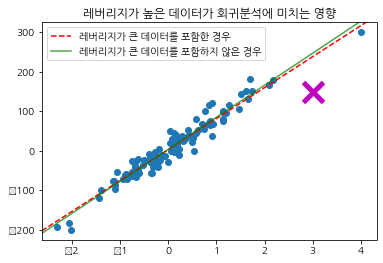

In [15]:
model2 = sm.OLS(y[:-1], X[:-1])
result2 = model2.fit()

ax = plt.subplot()
plt.scatter(X0, y)
sm.graphics.abline_plot(model_results=result,
                        c="r", linestyle="--", ax=ax)
sm.graphics.abline_plot(model_results=result2,
                        c="g", alpha=0.7, ax=ax)

plt.plot(X0[-1], y[-1], marker='x', c="m", ms=20, mew=5)
plt.legend([u"레버리지가 큰 데이터를 포함한 경우", u"레버리지가 큰 데이터를 포함하지 않은 경우"],
           loc="upper left")
plt.title("레버리지가 높은 데이터가 회귀분석에 미치는 영향")
plt.show()

In [16]:
# 레버리지 작은 데이터의 유무

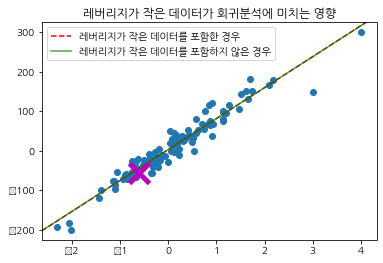

In [17]:
model3 = sm.OLS(y[1:], X[1:])
result3 = model3.fit()

ax = plt.subplot()
plt.scatter(X0, y)
sm.graphics.abline_plot(model_results=result,
                        c="r", linestyle="--", ax=ax)
sm.graphics.abline_plot(model_results=result3,
                        c="g", alpha=0.7, ax=ax)

plt.plot(X0[0], y[0], marker='x', c="m", ms=20, mew=5)
plt.legend([u"레버리지가 작은 데이터를 포함한 경우", u"레버리지가 작은 데이터를 포함하지 않은 경우"],
           loc="upper left")
plt.title("레버리지가 작은 데이터가 회귀분석에 미치는 영향")
plt.show()


In [18]:
# 레버리지 크더고 잔차가 작은 데이터의 유무
# 다른 데이터들이 따르는 법칙에 잘따르기 때문에 빼도 별 차이가 없음

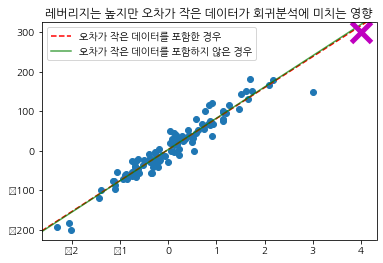

In [19]:
idx = np.array(list(range(100)) + [101])
model4 = sm.OLS(y[idx], X[idx, :])
result4 = model4.fit()

ax = plt.subplot()
plt.scatter(X0, y)
sm.graphics.abline_plot(model_results=result,
                        c="r", linestyle="--", ax=ax)
sm.graphics.abline_plot(model_results=result4,
                        c="g", alpha=0.7, ax=ax)

plt.plot(X0[-2], y[-2], marker='x', c="m", ms=20, mew=5)
plt.legend([u"오차가 작은 데이터를 포함한 경우", u"오차가 작은 데이터를 포함하지 않은 경우"],
           loc="upper left")
plt.title("레버리지는 높지만 오차가 작은 데이터가 회귀분석에 미치는 영향")
plt.show()

### statsmodels를 이용한 표준화  계산

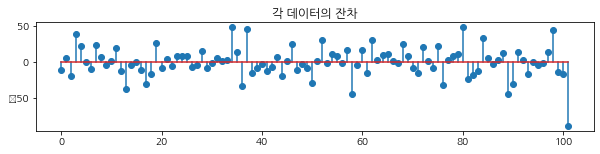

In [20]:
plt.figure(figsize=(10, 2))
plt.stem(result.resid)
plt.title("각 데이터의 잔차")
plt.show()

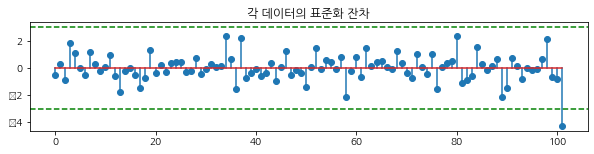

In [21]:
# 표준편차가 1인상태로 normalized된 잔차
plt.figure(figsize=(10, 2))
plt.stem(result.resid_pearson)
plt.axhline(3, c="g", ls="--")
plt.axhline(-3, c="g", ls="--")
plt.title("각 데이터의 표준화 잔차")
plt.show()

x축으로 표준화 잔차의 제곱을 표시하고 y축으로 레버리지값을 표시한다. 
데이터 아이디가 표시된 데이터들이 레버리지가 큰 아웃라이어이다.

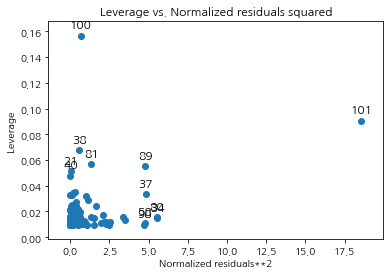

In [22]:
sm.graphics.plot_leverage_resid2(result)
plt.show()

influence_plot 명령을 사용하면 Cook's distance를 버블 크기로 표시한다.

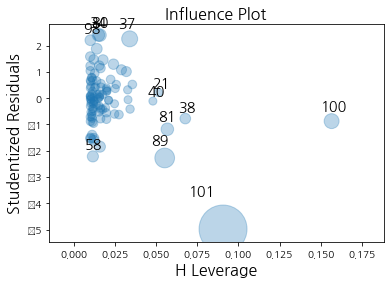

In [23]:
sm.graphics.influence_plot(result, plot_alpha=0.3)
plt.show()

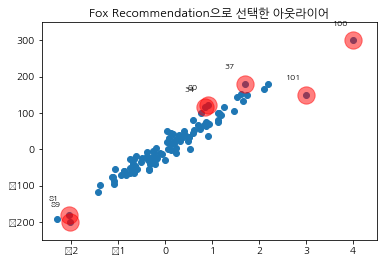

In [24]:
from statsmodels.graphics import utils

cooks_d2, pvals = influence.cooks_distance
K = influence.k_vars
fox_cr = 4 / (len(y) - K - 1)
idx = np.where(cooks_d2 > fox_cr)[0]

ax = plt.subplot()
plt.scatter(X0, y)
plt.scatter(X0[idx], y[idx], s=300, c="r", alpha=0.5)
utils.annotate_axes(range(len(idx)), idx,
                    list(zip(X0[idx], y[idx])), [(-20, 15)] * len(idx), size="small", ax=ax)
plt.title("Fox Recommendation으로 선택한 아웃라이어")
plt.show()

### 보스턴 집값 예측 문제

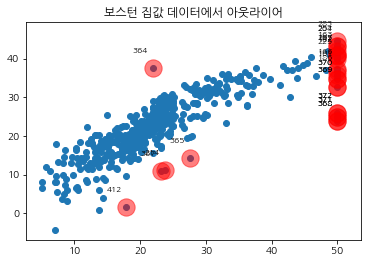

In [25]:
from sklearn.datasets import load_boston
boston = load_boston()

dfX0 = pd.DataFrame(boston.data, columns=boston.feature_names)
dfX = sm.add_constant(dfX0)
dfy = pd.DataFrame(boston.target, columns=["MEDV"])

model_boston = sm.OLS(dfy, dfX)
result_boston = model_boston.fit()
pred = result_boston.predict(dfX)

influence_boston = result_boston.get_influence()
cooks_d2, pvals = influence_boston.cooks_distance
K = influence.k_vars
fox_cr = 4 / (len(y) - K - 1)
idx = np.where(cooks_d2 > fox_cr)[0]

# MEDV = 50 제거
idx = np.hstack([idx, np.where(boston.target == 50)[0]])

ax = plt.subplot()
plt.scatter(dfy, pred)
plt.scatter(dfy.MEDV[idx], pred[idx], s=300, c="r", alpha=0.5)
utils.annotate_axes(range(len(idx)), idx,
                    list(zip(dfy.MEDV[idx], pred[idx])), [(-20, 15)] * len(idx), size="small", ax=ax)
plt.title("보스턴 집값 데이터에서 아웃라이어")
plt.show()
# 다 50으로 찍혀있는 데이터가 이상해 보임 
# -> 50보다 큰값들임에도 50으로 표시한건 아닐지 합리적 의심가능 ->뺴도 ㄱㅊ아보임
# 나머지 아웃라이어는 하나하나 뜯어봐야함


In [26]:
print(result_boston.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Tue, 19 May 2020   Prob (F-statistic):          6.72e-135
Time:                        15:51:34   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.4595      5.103      7.144      0.0

In [27]:
# 아웃라이어를 제거한 회귀분석결과 test-performence가 올라감 (R-squared)
# 퍼포먼스 올라갔다고 더 좋은 결과를 기대할 수는 없음
# 실제로 예측할 데이터들도 아웃라이어가 없어야 이 결과가 더 좋다고 말할 수 있을것
idx2 = list(set(range(len(dfX))).difference(idx))
dfX = dfX.iloc[idx2, :].reset_index(drop=True)
dfy = dfy.iloc[idx2, :].reset_index(drop=True)
model_boston2 = sm.OLS(dfy, dfX)
result_boston2 = model_boston2.fit()
print(result_boston2.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     156.1
Date:                Tue, 19 May 2020   Prob (F-statistic):          2.41e-161
Time:                        15:51:34   Log-Likelihood:                -1285.2
No. Observations:                 485   AIC:                             2598.
Df Residuals:                     471   BIC:                             2657.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.8999      4.107      4.602      0.0

### 분산분석

In [28]:
from sklearn.datasets import make_regression

X0, y, coef = make_regression(
    n_samples=100, n_features=1, noise=30, coef=True, random_state=0)
dfX0 = pd.DataFrame(X0, columns=["X"])
dfX = sm.add_constant(dfX0)
dfy = pd.DataFrame(y, columns=["Y"])
df = pd.concat([dfX, dfy], axis=1)

model = sm.OLS.from_formula("Y ~ X", data=df)
result = model.fit()

In [29]:
print("TSS = ", result.uncentered_tss)
print("ESS = ", result.mse_model)
print("RSS = ", result.ssr)
print("ESS + RSS = ", result.mse_model + result.ssr)
print("R squared = ", result.rsquared)

TSS =  291345.75789830607
ESS =  188589.61349210917
RSS =  102754.33755137533
ESS + RSS =  291343.9510434845
R squared =  0.6473091780922586


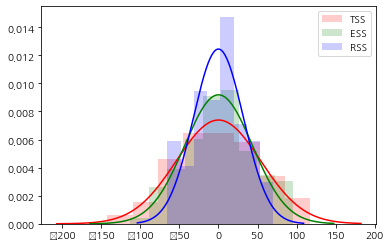

In [30]:
sns.distplot(y,
             kde=False, fit=sp.stats.norm, hist_kws={"color": "r", "alpha": 0.2}, fit_kws={"color": "r"},
             label="TSS")
sns.distplot(result.fittedvalues,
             kde=False, hist_kws={"color": "g", "alpha": 0.2}, fit=sp.stats.norm, fit_kws={"color": "g"},
             label="ESS")
sns.distplot(result.resid,
             kde=False, hist_kws={"color": "b", "alpha": 0.2}, fit=sp.stats.norm, fit_kws={"color": "b"},
             label="RSS")
plt.legend()
plt.show()

### 회귀분석 F검정과 분산분석의 관계

In [31]:
# anova_lm 명령을 사용하여 분산 분석표를 출력할 수 있다. 
# 다만 이 명령을 사용하기 위해서는 모형을 from_formula 메서드로 생성하여야 한다.
sm.stats.anova_lm(result)

,df,sum_sq,mean_sq,F,PR(>F)
X,1.0,188589.613492,188589.613492,179.863766,6.601482e-24
Residual,98.0,102754.337551,1048.513648,NaN,NaN


In [32]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     179.9
Date:                Tue, 19 May 2020   Prob (F-statistic):           6.60e-24
Time:                        15:51:35   Log-Likelihood:                -488.64
No. Observations:                 100   AIC:                             981.3
Df Residuals:                      98   BIC:                             986.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.4425      3.244     -0.753      0.4

In [33]:
# 위 둘의 F검정값이 같음
# F-검정과 분산분석은 같은 내용을 검정하는 것이었던것!

### 결정계수와 상관계수

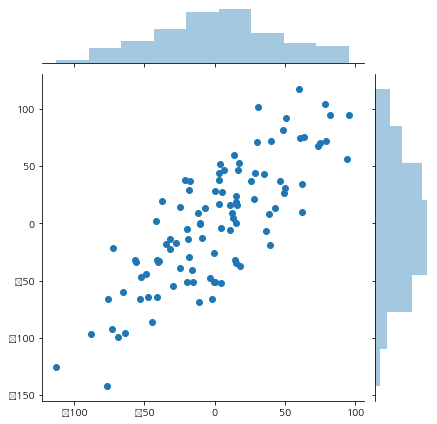

In [34]:
sns.jointplot(result.fittedvalues, y)
plt.show()

### 상수항이 없는 모형

In [35]:
X0, y, coef = make_regression(
    n_samples=100, n_features=1, noise=30, bias=100, coef=True, random_state=0)
dfX = pd.DataFrame(X0, columns=["X"])
dfy = pd.DataFrame(y, columns=["Y"])
df = pd.concat([dfX, dfy], axis=1)

model2 = sm.OLS.from_formula("Y ~ X + 0", data=df)
result2 = model2.fit()

In [36]:
result2.rsquared

0.18768724705943896

In [37]:
# 상수항이 있는 모형과 없는모형의 결정계수 비교하면 안됨
# 상수항이 없는경우  TSS계산시 Y bar가 0이라고 가정하기 떄문
# 가정하지 않으면 결정계수값이 1보다 커지게됨

### F검정을 이용한 모형 비교
```
StatsModels에서는 anova_lm 명령에 두 모형의 result 객체를 인수로 넣어주면 
이러한 검정을 할 수 있다. 
인수를 넣어줄 때는 축소 모형(reduced model), 전체 모형(full model)의 순서로 넣어준다.
```

In [38]:
boston = load_boston()
dfX0_boston = pd.DataFrame(boston.data, columns=boston.feature_names)
dfy_boston = pd.DataFrame(boston.target, columns=["MEDV"])
dfX_boston = sm.add_constant(dfX0_boston)
df_boston = pd.concat([dfX_boston, dfy_boston], axis=1)

In [39]:
model_full = sm.OLS.from_formula(
    "MEDV ~ CRIM + ZN + INDUS + NOX + RM + AGE + DIS + RAD + TAX + PTRATIO + B + LSTAT + CHAS", data=df_boston)
model_reduced = sm.OLS.from_formula(
    "MEDV ~ CRIM + ZN + NOX + RM + DIS + RAD + TAX + PTRATIO + B + LSTAT + CHAS", data=df_boston)

sm.stats.anova_lm(model_reduced.fit(), model_full.fit())

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,494.0,11081.363952,0.0,NaN,NaN,NaN
1,492.0,11078.784578,2.0,2.579374,0.057274,0.944342


In [40]:
# 위결과 귀무가설 채택(H0: w2=w3=0) -> 축소모형을 써도 상관없다 동일하다

### F검정을 사용한 변수 중요도 비교

In [41]:
model_full = sm.OLS.from_formula(
    "MEDV ~ CRIM + ZN + INDUS + NOX + RM + AGE + DIS + RAD + TAX + PTRATIO + B + LSTAT + CHAS", data=df_boston)
model_reduced = sm.OLS.from_formula(
    "MEDV ~ ZN + INDUS + NOX + RM + AGE + DIS + RAD + TAX + PTRATIO + B + LSTAT + CHAS", data=df_boston)

sm.stats.anova_lm(model_reduced.fit(), model_full.fit())

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,493.0,11322.004277,0.0,NaN,NaN,NaN
1,492.0,11078.784578,1.0,243.219699,10.801193,0.001087


### 6.1 모형의 진단과 수정

### 잔차 정규성

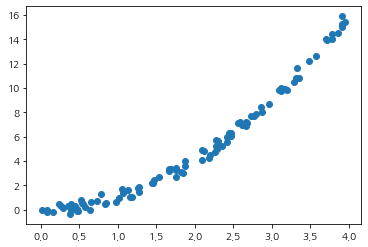

In [42]:
def make_regression2(n_sample=100, bias=0, noise=0.3, random_state=0):
    np.random.seed(random_state)
    x = np.random.rand(n_sample) * 4
    epsilon = noise * np.random.randn(n_sample)
    y = x ** 2 + bias + epsilon
    return x, y


x2, y2 = make_regression2()
plt.scatter(x2, y2)
plt.show()


In [43]:
dfX20 = pd.DataFrame(x2, columns=["X1"])
dfX2 = sm.add_constant(dfX20)
dfy2 = pd.DataFrame(y2, columns=["y"])

model2 = sm.OLS(dfy2, dfX2)
result2 = model2.fit()

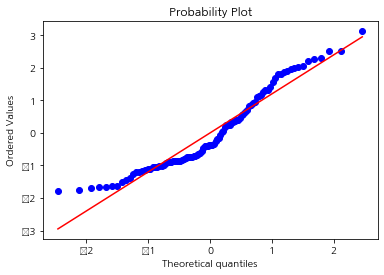

In [44]:
sp.stats.probplot(result2.resid, plot=plt)
plt.show()

In [45]:
test = sm.stats.omni_normtest(result2.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       :  9.520
P-value     :  0.009


### 잔차와 독립변수의 관계

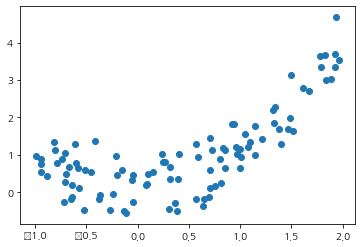

In [46]:
def make_regression3(n_sample=100, bias=0, noise=0.5, random_state=0):
    np.random.seed(random_state)
    x = np.random.rand(n_sample) * 3 - 1
    epsilon = noise * np.random.randn(n_sample)
    y = x ** 2 + bias + epsilon
    return x, y


x3, y3 = make_regression3()
plt.scatter(x3, y3)
plt.show()

In [47]:
dfX30 = pd.DataFrame(x3, columns=["X1"])
dfX3 = sm.add_constant(dfX30)
dfy3 = pd.DataFrame(y3, columns=["y"])

model3 = sm.OLS(dfy3, dfX3)
result3 = model3.fit()

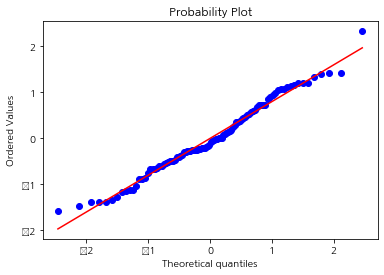

In [48]:
sp.stats.probplot(result3.resid, plot=plt)
plt.show()
# x가 선형이 아니지만 잔차는 정규분포를 따르는것으로 보임

In [49]:
test = sm.stats.omni_normtest(result3.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)
# 검정결과도 정규분포를 따르는 것으로 나옴

Chi^2       :  1.202
P-value     :  0.548


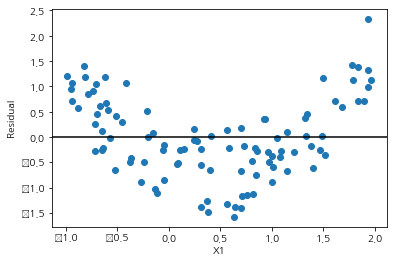

In [50]:
plt.plot(x3, result3.resid, 'o')
plt.axhline(y=0, c='k')
plt.xlabel("X1")
plt.ylabel("Residual")
plt.show()

### 이분산성

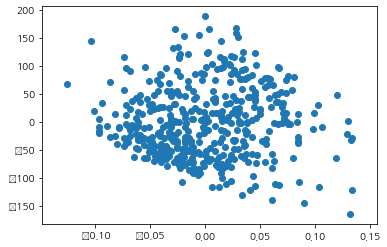

In [51]:
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()
df = pd.concat([pd.DataFrame(diabetes.data, columns=["x%d" % (i + 1) for i in range(diabetes.data.shape[1])]),
                pd.DataFrame(diabetes.target, columns=["target"])],
               axis=1)
model = sm.OLS.from_formula("target ~ x9", data=df)
result = model.fit()
plt.scatter(df["x9"], result.resid)
plt.show()

### 비선형 변경

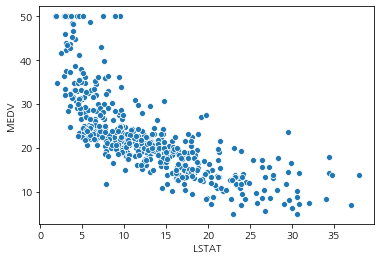

In [52]:
from sklearn.datasets import load_boston

boston = load_boston()
dfX = pd.DataFrame(boston.data, columns=boston.feature_names)
dfy = pd.DataFrame(boston.target, columns=["MEDV"])
df_boston = pd.concat([dfX, dfy], axis=1)

sns.scatterplot(x="LSTAT", y="MEDV", data=df_boston)
plt.show()

In [53]:
# 일반 선형모형
model1 = sm.OLS.from_formula("MEDV ~ LSTAT", data=df_boston)
result1 = model1.fit()
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Tue, 19 May 2020   Prob (F-statistic):           5.08e-88
Time:                        15:51:40   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     34.5538      0.563     61.415      0.0

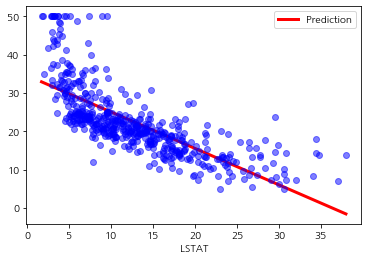

In [54]:
y_hat1 = result1.predict(df_boston)
df1 = pd.concat([y_hat1, df_boston.LSTAT], axis=1).sort_values("LSTAT")
df1.columns = ["Prediction", "LSTAT"]
df1.plot(x="LSTAT", style="r-", lw=3)
plt.plot(df_boston.LSTAT, df_boston.MEDV, "bo", alpha=0.5)
plt.show()

In [55]:
# 비선형 독립변수 추가( 2차항)
model2 = sm.OLS.from_formula("MEDV ~ LSTAT + I(LSTAT**2)", data=df_boston)
result2 = model2.fit()
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     448.5
Date:                Tue, 19 May 2020   Prob (F-statistic):          1.56e-112
Time:                        15:51:40   Log-Likelihood:                -1581.3
No. Observations:                 506   AIC:                             3169.
Df Residuals:                     503   BIC:                             3181.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        42.8620      0.872     49.149

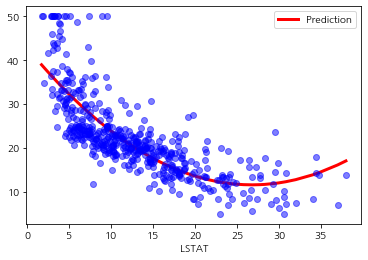

In [56]:
y_hat2 = result2.predict(df_boston)
df2 = pd.concat([y_hat2, df_boston.LSTAT], axis=1).sort_values("LSTAT")
df2.columns = ["Prediction", "LSTAT"]
df2.plot(x="LSTAT", style="r-", lw=3)
plt.plot(df_boston.LSTAT, df_boston.MEDV, "bo", alpha=0.5)
plt.show()

### 범주형을 사용한 비선형성

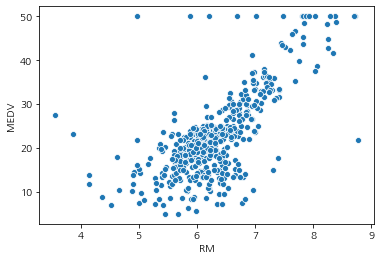

In [57]:
sns.scatterplot(x="RM", y="MEDV", data=df_boston)
plt.show()

In [58]:
model3 = sm.OLS.from_formula("MEDV ~ RM", data=df_boston)
result3 = model3.fit()
print(result3.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     471.8
Date:                Tue, 19 May 2020   Prob (F-statistic):           2.49e-74
Time:                        15:51:41   Log-Likelihood:                -1673.1
No. Observations:                 506   AIC:                             3350.
Df Residuals:                     504   BIC:                             3359.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -34.6706      2.650    -13.084      0.0

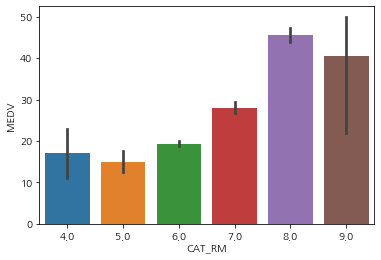

In [59]:
rooms = np.arange(3, 10)
labels = [str(r) for r in rooms[:-1]]
df_boston["CAT_RM"] = np.round(df_boston.RM)

sns.barplot(x="CAT_RM", y="MEDV", data=df_boston)
plt.show()

In [60]:
model4 = sm.OLS.from_formula("MEDV ~ C(np.round(RM))", data=df_boston)
result4 = model4.fit()
print(result4.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     115.8
Date:                Tue, 19 May 2020   Prob (F-statistic):           3.57e-81
Time:                        15:51:42   Log-Likelihood:                -1645.6
No. Observations:                 506   AIC:                             3303.
Df Residuals:                     500   BIC:                             3329.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 17

### 시간독립변수의 변형
```
datetime 자료형은 toordinal 명령으로 특정 시점으로부터 
경과한 시간의 일단위 값을 구하거나 timestamp 메서드로 초단위 값을 구할 수 있다.
```

In [61]:
data = sm.datasets.get_rdataset("elecdaily", package="fpp2")

df_elec = data.data.drop(columns=["WorkDay", "Temperature"])
df_elec["Date"] = pd.date_range("2014-1-1", "2014-12-31")
df_elec.tail()

,Demand,Date
360,173.727990,2014-12-27
361,188.512817,2014-12-28
362,191.273009,2014-12-29
363,186.240144,2014-12-30
364,186.370181,2014-12-31


In [62]:
import datetime as dt

df_elec["Ordinal"] = df_elec.Date.map(dt.datetime.toordinal)
df_elec["Timestamp"] = df_elec.Date.map(dt.datetime.timestamp)
df_elec.tail()

,Demand,Date,Ordinal,Timestamp
360,173.727990,2014-12-27,735594,1.419606e+09
361,188.512817,2014-12-28,735595,1.419692e+09
362,191.273009,2014-12-29,735596,1.419779e+09
363,186.240144,2014-12-30,735597,1.419865e+09
364,186.370181,2014-12-31,735598,1.419952e+09


In [63]:
# 시간 값의 경우 크기가 크므로 반드시 스케일링 해주어야 한다
model5 = sm.OLS.from_formula("Demand ~ scale(Ordinal)", data=df_elec)
result5 = model5.fit()
print(result5.summary())

                            OLS Regression Results                            
Dep. Variable:                 Demand   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     11.58
Date:                Tue, 19 May 2020   Prob (F-statistic):           0.000739
Time:                        15:51:45   Log-Likelihood:                -1709.7
No. Observations:                 365   AIC:                             3423.
Df Residuals:                     363   BIC:                             3431.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        221.2775      1.374    160.

In [64]:
# 추가적으로 이러한 값들도 임베딩 가능
df_elec["Year"] = df_elec.Date.dt.year
df_elec["Month"] = df_elec.Date.dt.month
df_elec["DayOfYear"] = df_elec.Date.dt.dayofyear
df_elec["DayOfMonth"] = df_elec.Date.dt.daysinmonth
df_elec["DayOfWeek"] = df_elec.Date.dt.dayofweek
df_elec["WeekOfYear"] = df_elec.Date.dt.weekofyear
df_elec["Weekday"] = df_elec.Date.dt.weekday
df_elec["IsMonthStart"] = df_elec.Date.dt.is_month_start
df_elec["IsMonthEnd"] = df_elec.Date.dt.is_month_end
df_elec.tail()

,Demand,Date,Ordinal,Timestamp,Year,Month,DayOfYear,DayOfMonth,DayOfWeek,WeekOfYear,Weekday,IsMonthStart,IsMonthEnd
360,173.727990,2014-12-27,735594,1.419606e+09,2014,12,361,31,5,52,5,False,False
361,188.512817,2014-12-28,735595,1.419692e+09,2014,12,362,31,6,52,6,False,False
362,191.273009,2014-12-29,735596,1.419779e+09,2014,12,363,31,0,1,0,False,False
363,186.240144,2014-12-30,735597,1.419865e+09,2014,12,364,31,1,1,1,False,False
364,186.370181,2014-12-31,735598,1.419952e+09,2014,12,365,31,2,1,2,False,True


In [65]:
feature_names = df_elec.columns.tolist()
feature_names.remove("Demand")
feature_names.remove("Date")

formula = """
Demand ~ scale(Ordinal) + C(Month) + DayOfYear + 
         C(DayOfMonth) + C(DayOfWeek) + C(Weekday) + C(IsMonthStart) + C(IsMonthEnd)
"""
model6 = sm.OLS.from_formula(formula, data=df_elec)
result6 = model6.fit()
print(result6.summary())

                            OLS Regression Results                            
Dep. Variable:                 Demand   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     19.98
Date:                Tue, 19 May 2020   Prob (F-statistic):           4.74e-46
Time:                        15:51:46   Log-Likelihood:                -1574.8
No. Observations:                 365   AIC:                             3192.
Df Residuals:                     344   BIC:                             3273.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

### 주기성을 가지는 독립변수

In [66]:
from sklearn.datasets import fetch_covtype

In [67]:
covtype = fetch_covtype()

feature_names = ["Aspect", "Hillshade_9am"]
df_covtype = pd.DataFrame(covtype.data[:, [1, 6]], columns=feature_names)
df_covtype = df_covtype.sample(10000, random_state=0)  # 편의상 10,000개 표본 추출
df_covtype.tail()

ValueError: EOF: reading array data, expected 262144 bytes got 148349

In [68]:
# scikit_learn_data 폴더에 covertype에 문제가 있는듯함
# 교재로 보기..

### 종속변수 변형

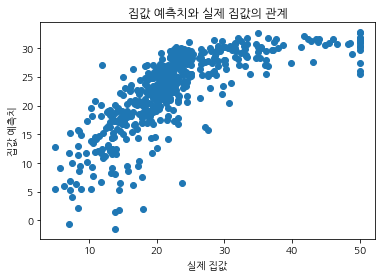

In [69]:
plt.scatter(boston.target, y_hat1)
plt.xlabel(u"실제 집값")
plt.ylabel(u"집값 예측치")
plt.title("집값 예측치와 실제 집값의 관계")
plt.show()

In [70]:
# 종속변소에 루트변형 시켜줌
model11 = sm.OLS.from_formula("np.sqrt(MEDV) ~ LSTAT", data=df_boston)
result11 = model11.fit()
print(result11.summary())

                            OLS Regression Results                            
Dep. Variable:          np.sqrt(MEDV)   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     789.7
Date:                Tue, 19 May 2020   Prob (F-statistic):          3.09e-105
Time:                        16:16:20   Log-Likelihood:                -445.65
No. Observations:                 506   AIC:                             895.3
Df Residuals:                     504   BIC:                             903.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.9499      0.053    112.374      0.0

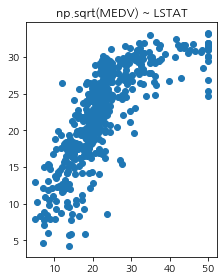

In [71]:
plt.scatter(boston.target, y_hat1)
plt.title("MEDV ~ LSTAT")
plt.subplot(122)
plt.scatter(boston.target, (result11.predict(df_boston))**2)
plt.title("np.sqrt(MEDV) ~ LSTAT")
plt.tight_layout()
plt.show()

In [72]:
# 종속변수에 로그변환
model12 = sm.OLS.from_formula("np.log(MEDV) ~ LSTAT", data=df_boston)
result12 = model12.fit()
print(result12.summary())

                            OLS Regression Results                            
Dep. Variable:           np.log(MEDV)   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     928.1
Date:                Tue, 19 May 2020   Prob (F-statistic):          2.23e-116
Time:                        16:16:53   Log-Likelihood:               -0.57634
No. Observations:                 506   AIC:                             5.153
Df Residuals:                     504   BIC:                             13.61
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.6176      0.022    164.654      0.0

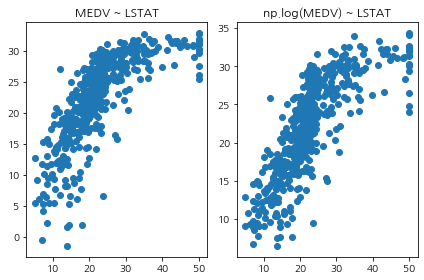

In [73]:
plt.subplot(121)
plt.scatter(boston.target, y_hat1)
plt.title("MEDV ~ LSTAT")
plt.subplot(122)
plt.scatter(boston.target, np.exp(result12.predict(df_boston)))
plt.title("np.log(MEDV) ~ LSTAT")
plt.tight_layout()
plt.show()

In [74]:
# 종속하고 독립변수에 로그 변환
model13 = sm.OLS.from_formula("np.log(MEDV) ~ np.log(LSTAT)", data=df_boston)
result13 = model13.fit()
print(result13.summary())

                            OLS Regression Results                            
Dep. Variable:           np.log(MEDV)   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     1058.
Date:                Tue, 19 May 2020   Prob (F-statistic):          7.32e-126
Time:                        16:17:20   Log-Likelihood:                 21.325
No. Observations:                 506   AIC:                            -38.65
Df Residuals:                     504   BIC:                            -30.20
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         4.3618      0.042    103.603

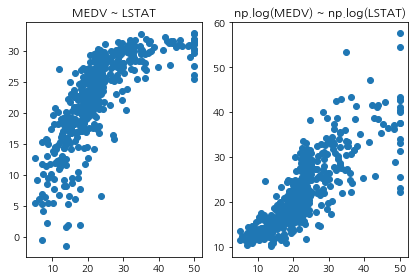

In [75]:
plt.subplot(121)
plt.scatter(boston.target, y_hat1)
plt.title("MEDV ~ LSTAT")
plt.subplot(122)
plt.scatter(boston.target, np.exp(result13.predict(df_boston)))
plt.title("np.log(MEDV) ~ np.log(LSTAT)")
plt.tight_layout()
plt.show()

### 6.2 기저 함수모형과 과최적화

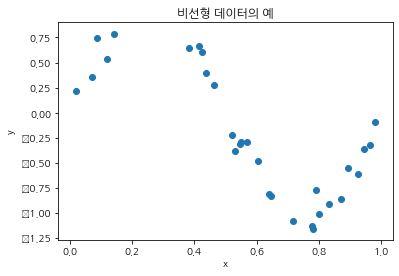

In [7]:
def make_nonlinear(seed=0):
    np.random.seed(seed)
    n_samples = 30
    X = np.sort(np.random.rand(n_samples))
    y = np.sin(2 * np.pi * X) + np.random.randn(n_samples) * 0.1
    X = X[:, np.newaxis]
    return (X, y)

X, y = make_nonlinear()
plt.scatter(X, y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("비선형 데이터의 예")
plt.show()

### 기저함수

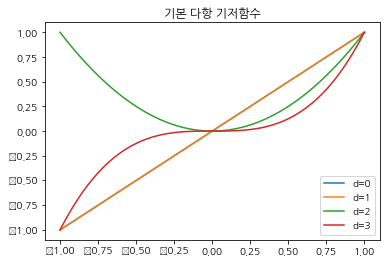

In [3]:
phi_0 = np.polynomial.Polynomial.basis(1)
phi_1 = np.polynomial.Polynomial.basis(1)
phi_2 = np.polynomial.Polynomial.basis(2)
phi_3 = np.polynomial.Polynomial.basis(3)

x = np.linspace(-1, 1, 100)

plt.plot(x, phi_0(x), label="d=0")
plt.plot(x, phi_1(x), label="d=1")
plt.plot(x, phi_2(x), label="d=2")
plt.plot(x, phi_3(x), label="d=3")
plt.legend()
plt.title("기본 다항 기저함수")
plt.show()


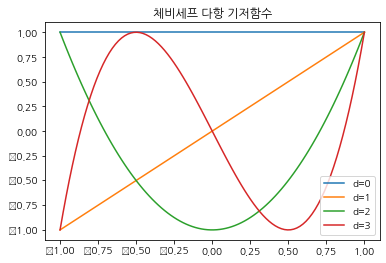

In [4]:
phi_0 = np.polynomial.chebyshev.Chebyshev.basis(0)
phi_1 = np.polynomial.chebyshev.Chebyshev.basis(1)
phi_2 = np.polynomial.chebyshev.Chebyshev.basis(2)
phi_3 = np.polynomial.chebyshev.Chebyshev.basis(3)

x = np.linspace(-1, 1, 100)

plt.plot(x, phi_0(x), label="d=0")
plt.plot(x, phi_1(x), label="d=1")
plt.plot(x, phi_2(x), label="d=2")
plt.plot(x, phi_3(x), label="d=3")
plt.legend()
plt.title("체비세프 다항 기저함수")
plt.show()

### StatsModels를 이용한 다항회귀

In [8]:
dfX = pd.DataFrame(X, columns=["x"])
dfX = sm.add_constant(dfX)
dfy = pd.DataFrame(y, columns=["y"])
df = pd.concat([dfX, dfy], axis=1)

print(sm.OLS.from_formula("y ~ x", data=df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     36.36
Date:                Tue, 19 May 2020   Prob (F-statistic):           1.69e-06
Time:                        19:36:43   Log-Likelihood:                -15.360
No. Observations:                  30   AIC:                             34.72
Df Residuals:                      28   BIC:                             37.52
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7140      0.176      4.064      0.0

In [9]:
print(sm.OLS.from_formula("y ~ x + I(x**2)", data=df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     18.38
Date:                Tue, 19 May 2020   Prob (F-statistic):           9.14e-06
Time:                        19:37:11   Log-Likelihood:                -14.953
No. Observations:                  30   AIC:                             35.91
Df Residuals:                      27   BIC:                             40.11
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8638      0.248      3.487      0.0

In [12]:
#3차 다항회귀까지 추가
# 높아진 결정계수
print(sm.OLS.from_formula("y ~ x + I(x**2) + I(x**3)", data=df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     186.7
Date:                Tue, 19 May 2020   Prob (F-statistic):           1.06e-17
Time:                        19:37:45   Log-Likelihood:                 18.883
No. Observations:                  30   AIC:                            -29.77
Df Residuals:                      26   BIC:                            -24.16
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2039      0.109     -1.876      0.0

In [13]:
def polyreg(degree, seed=0, ax=None):
    X, y = make_nonlinear(seed)

    dfX = pd.DataFrame(X, columns=["x"])
    dfX = sm.add_constant(dfX)
    dfy = pd.DataFrame(y, columns=["y"])
    df = pd.concat([dfX, dfy], axis=1)

    model_str = "y ~ "
    for i in range(degree):
        if i == 0:
            prefix = ""
        else:
            prefix = " + "
        model_str += prefix + "I(x**{})".format(i + 1)
    model = sm.OLS.from_formula(model_str, data=df)
    result = model.fit()

    if ax:
        ax.scatter(X, y)
        xx = np.linspace(0, 1, 1000)
        dfX_new = pd.DataFrame(xx[:, np.newaxis], columns=["x"])
        ax.plot(xx, result.predict(dfX_new))
        ax.set_ylim(-2, 2)
        ax.set_title("차수={}, 시드값={}".format(degree, seed))
        xlabel = "\n".join(str(result.params).split("\n")[:-1])
        font = {'family': 'NanumGothicCoding', 'color':  'black', 'size': 10}
        ax.set_xlabel(xlabel, fontdict=font)

    return result

findfont: Font family ['NanumGothicCoding'] not found. Falling back to DejaVu Sans.


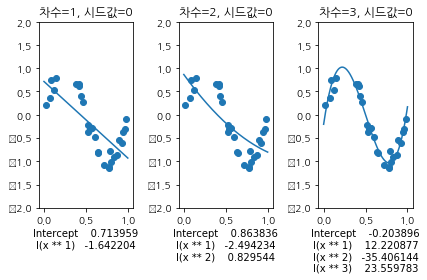

In [14]:
ax1 = plt.subplot(131)
polyreg(1, ax=ax1)
ax2 = plt.subplot(132)
polyreg(2, ax=ax2)
ax3 = plt.subplot(133)
polyreg(3, ax=ax3)
plt.tight_layout()
plt.show()

### 과최적화

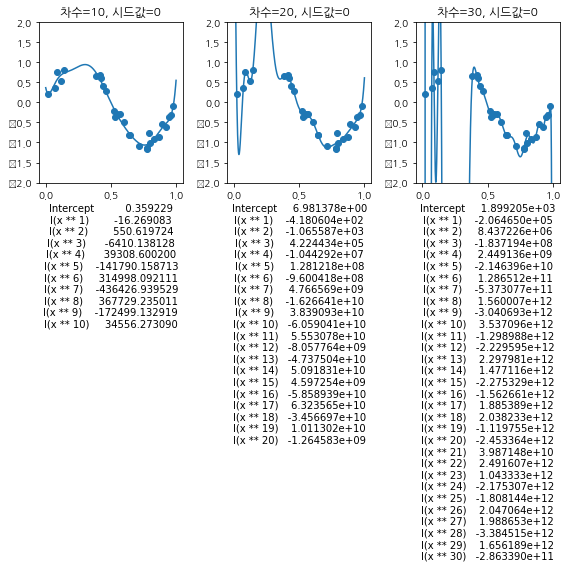

In [15]:
plt.figure(figsize=(8, 8))
ax1 = plt.subplot(131)
polyreg(10, ax=ax1)
ax2 = plt.subplot(132)
polyreg(20, ax=ax2)
ax3 = plt.subplot(133)
polyreg(30, ax=ax3)
plt.tight_layout()
plt.show()

### 검증용 데이터 집합

In [17]:
# train데이터와 test데이터 분리해주는 함수 따로 없어 직접해야함
from sklearn.datasets import load_boston

boston = load_boston()
dfX = pd.DataFrame(boston.data, columns=boston.feature_names)
dfy = pd.DataFrame(boston.target, columns=["MEDV"])
df = pd.concat([dfX, dfy], axis=1)

N = len(df)
ratio = 0.7
np.random.seed(0)
idx_train = np.random.choice(np.arange(N), np.int(ratio * N))
idx_test = list(set(np.arange(N)).difference(idx_train))

df_train = df.iloc[idx_train]
df_test = df.iloc[idx_test]

In [19]:
# 학습용데이터로 만든 회귀모형
model = sm.OLS.from_formula("MEDV ~ " + "+".join(boston.feature_names), data=df_train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     81.31
Date:                Tue, 19 May 2020   Prob (F-statistic):           7.22e-96
Time:                        20:03:58   Log-Likelihood:                -1057.6
No. Observations:                 354   AIC:                             2143.
Df Residuals:                     340   BIC:                             2197.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     40.6105      6.807      5.966      0.0

In [20]:
# 남겨둔 test데이터로 구한 결정계수
# ols쓰면 안됨 -> 그럼 모형을 또 만드는 거니까 
# 직접 입력해 줘야함
pred = result.predict(df_test)

rss = ((df_test.MEDV - pred) ** 2).sum()
tss = ((df_test.MEDV - df_test.MEDV.mean())** 2).sum()
rsquared = 1 - rss / tss
rsquared

0.688373412498711

### K-fold교차검증

In [21]:
from sklearn.model_selection import KFold

scores = np.zeros(5)
cv = KFold(5, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df)):
    df_train = df.iloc[idx_train]
    df_test = df.iloc[idx_test]
    
    model = sm.OLS.from_formula("MEDV ~ " + "+".join(boston.feature_names), data=df_train)
    result = model.fit()
    
    pred = result.predict(df_test)
    rss = ((df_test.MEDV - pred) ** 2).sum()
    tss = ((df_test.MEDV - df_test.MEDV.mean())** 2).sum()
    rsquared = 1 - rss / tss
    
    scores[i] = rsquared
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

학습 R2 = 0.77301356, 검증 R2 = 0.58922238
학습 R2 = 0.72917058, 검증 R2 = 0.77799144
학습 R2 = 0.74897081, 검증 R2 = 0.66791979
학습 R2 = 0.75658611, 검증 R2 = 0.66801630
학습 R2 = 0.70497483, 검증 R2 = 0.83953317


### 평가점수

In [22]:
from sklearn.metrics import r2_score

scores = np.zeros(5)
cv = KFold(5, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df)):
    df_train = df.iloc[idx_train]
    df_test = df.iloc[idx_test]
    
    model = sm.OLS.from_formula("MEDV ~ " + "+".join(boston.feature_names), data=df_train)
    result = model.fit()
    
    pred = result.predict(df_test)
    rsquared = r2_score(df_test.MEDV, pred)
    
    scores[i] = rsquared

scores

array([0.58922238, 0.77799144, 0.66791979, 0.6680163 , 0.83953317])